# Analyze the performance of the classification model for 30 tree species based on LeafSnap data subset

### Settings

In [2]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

Using TensorFlow backend.


### Load the data 

In [3]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand,sep=r'\s*,\s*',header=0, encoding='ascii', engine='python')

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Get the test data

In [4]:
[_, _, images_test,_, _, labels_one_hot_test,end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)

Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Indicies:  4295 ,  5522


In [5]:
# splitting some of of the info data
labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

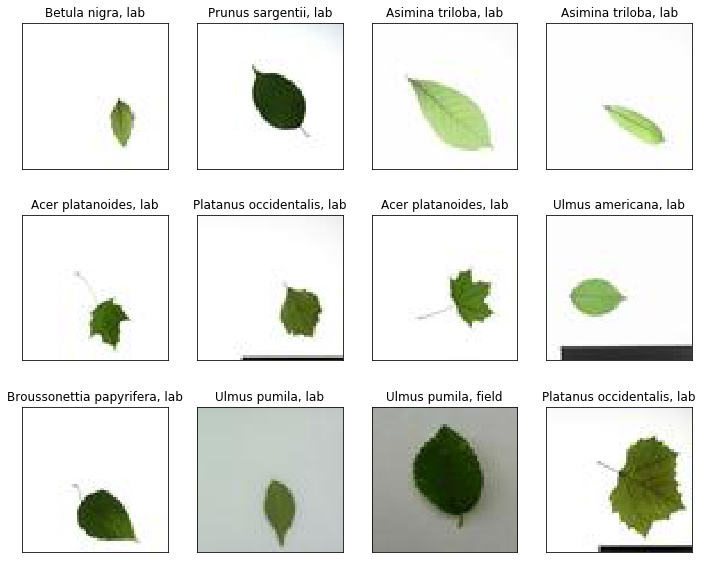

In [6]:
# plot random test images
d.plot_12images(images_test, labels_test, sources_test, figsize=(12,10))

### Load the model

In [7]:
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Loading the best model...
Best Model loaded!


### Create a dataset with predicted labels

In [8]:
pred = model.predict_classes(images_test)
predictions= pd.DataFrame({'prediction': pred, 'label_numeric': labels_numeric_test, 'label': labels_test, 'source': sources_test, 'filename':filenames_test, 'path':path_test})
#order columns
predictions = predictions[['prediction', 'label_numeric', 'label', 'source', 'filename', 'path']]
predictions.head()

,prediction,label_numeric,label,source,filename,path
5522,27,27,Abies concolor,lab,ny1178-10-1.jpg,dataset/images/lab/Auto_cropped/abies_concolor...
5523,17,22,Acer rubrum,lab,pi2773-04-4.jpg,dataset/images/lab/Auto_cropped/acer_rubrum/pi...
5524,28,17,Ulmus americana,lab,pi0020-02-2.jpg,dataset/images/lab/Auto_cropped/ulmus_american...
5525,4,5,Celtis occidentalis,field,1248106179_0005.jpg,dataset/images/field/celtis_occidentalis/12481...
5526,7,7,Magnolia acuminata,lab,wb1221-02-1.jpg,dataset/images/lab/Auto_cropped/magnolia_acumi...


### Confusion matrix

col_0,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
label_numeric,,,,,,,,,,,,,,,,,,,,,
0,5,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,14,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,14,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,8,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,0,0,0,0,9,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


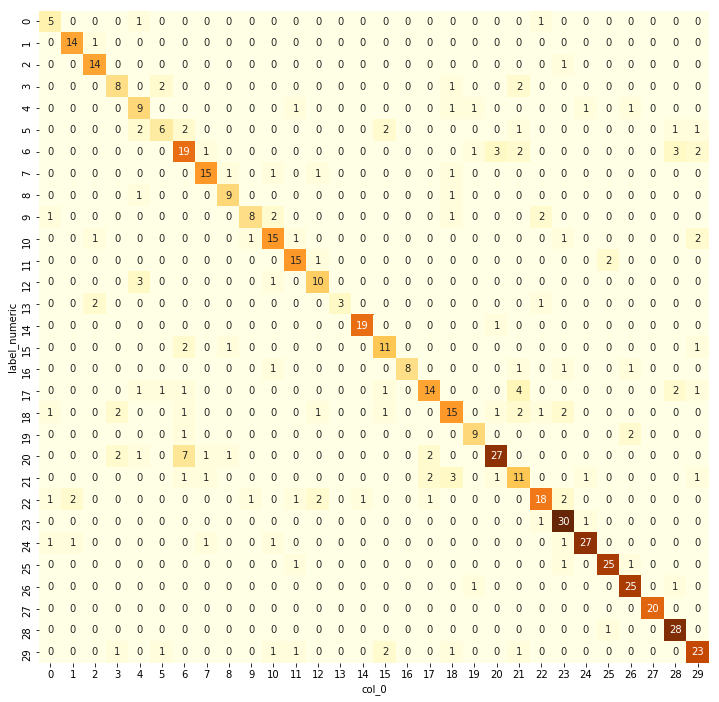

In [9]:
#calculate and  viualize the confusion matrix
df_confusion = pd.crosstab(labels_numeric_test, pred)
import seaborn as sns
plt.figure(figsize=[12,12])
sns.heatmap(df_confusion, cmap = "YlOrBr", annot=True, cbar = False)
df_confusion.head()

In [10]:
info_data_unique = info_data[['label', 'label_numeric']]
info_data_unique = info_data_unique.drop_duplicates(keep='first').sort_values('label_numeric').reset_index(drop=True)
info_data_unique.head(30)

,label,label_numeric
0,Acer campestre,0
1,Acer platanoides,1
2,Aesculus hippocastamon,2
3,Betula lenta,3
4,Betula nigra,4
5,Celtis occidentalis,5
6,Diospyros virginiana,6
7,Magnolia acuminata,7
8,Magnolia grandiflora,8
9,Platanus acerifolia,9


### Visualize 1 image per species

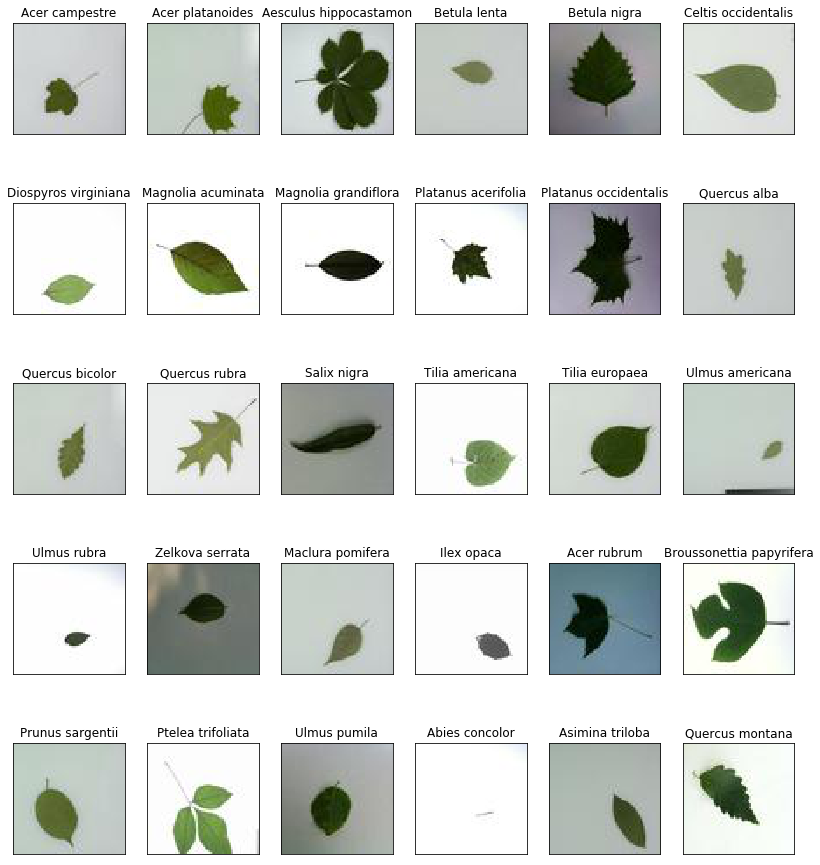

In [141]:
plt.figure(figsize=[14,16])
for i in range(30):
    species = info_data_unique['label'].iloc[i]
    index = info_data[info_data['label']==species].index[0]
    img = images[index,:]
    plt.subplot(5,6,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(species)

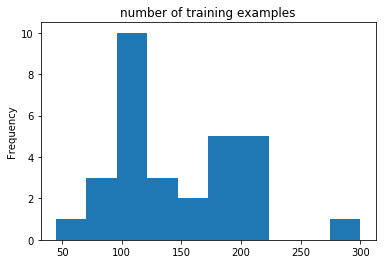

In [12]:
#number of examples per class in training set
training_examples = info_data.iloc[0:end_train_ind,:]
examples_per_label = training_examples.label.value_counts()
examples_per_label.plot(kind="hist", title="number of training examples")

The majority of classes hold approximately 100 examples, least is about 50 examples.

In [13]:
#incorrect predictions
incorrect = predictions[predictions["label_numeric"] != predictions["prediction"]]
incorrect = incorrect[['prediction', 'label_numeric', 'label', 'source', 'filename', 'path']]

#number of mistakes per class in test set
mistakes_per_label = incorrect.label.value_counts()

#pull together in df
examples_vs_mistakes = pd.DataFrame({'examples': examples_per_label, 'errors': mistakes_per_label})
#all species no mistakes were made on appear as NA, set them to 0
examples_vs_mistakes = examples_vs_mistakes.fillna(value=0)
#calculate error amount
examples_vs_mistakes["error_amount"] = examples_vs_mistakes["errors"] / examples_vs_mistakes["examples"]

print("Correlation is", examples_vs_mistakes["error_amount"].corr(examples_vs_mistakes["examples"]))

Correlation is -0.14243199711524746


Text(0.5,1,'Amount of training examples vs errors on test set')

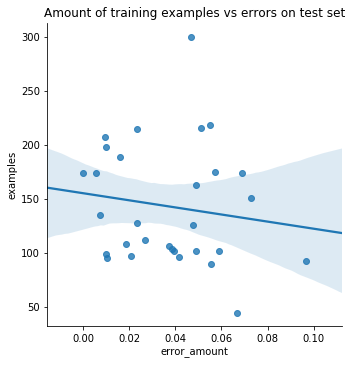

In [14]:
sns.lmplot(x='error_amount',y='examples',data=examples_vs_mistakes,fit_reg=True)
ax = plt.gca()
ax.set_title("Amount of training examples vs errors on test set")

### Is the performance different for lab/field pictures?

Is the model more prone to making errors when classifying pictures taken in the lab vs in the field?

    Amount of lab pictures misclassified
    Amount of field pictures misclassified



In [15]:
lab_errors = incorrect[incorrect["source"] == "lab"]
amount_lab_errors = len(lab_errors)/len(predictions[predictions["source"] == "lab"])

field_errors = incorrect[incorrect["source"] == "field"]
amount_field_errors = len(field_errors)/len(predictions[predictions["source"] == "field"])

print("Error amount lab picures: " + str(amount_lab_errors))
print("Error amount field pictures: " + str(amount_field_errors))

Error amount lab picures: 0.25894736842105265
Error amount field pictures: 0.22302158273381295


Field pictures were classified with a bit of less error!?

### Show examples of classes the model could predict worst/best

On which classes did the model perform well and which were often misclassified?

In [28]:
# List allsorted on error
examples_vs_mistakes_sorted = examples_vs_mistakes.sort_values('error_amount')

Lowest error rate:

In [134]:
errors_min6 = examples_vs_mistakes_sorted.head(6)
errors_min6

,examples,errors,error_amount
Abies concolor,174,0.0,0.000000
Asimina triloba,174,1.0,0.005747
Salix nigra,135,1.0,0.007407
Broussonettia papyrifera,207,2.0,0.009662
Ulmus pumila,198,2.0,0.010101
Aesculus hippocastamon,99,1.0,0.010101


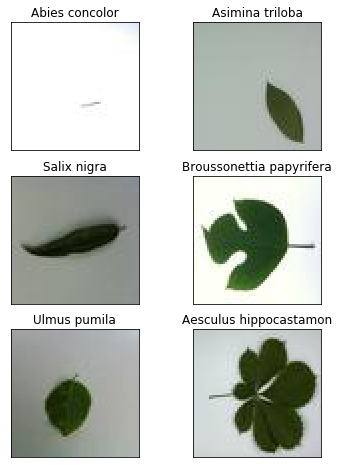

In [139]:
# display top 6
plt.figure(figsize=[6,8])
for i in range(6):
    species = errors_min6.iloc[i].name
    index = info_data[info_data['label']==species].index[0]
    img = images[index,:]
    plt.subplot(3,2,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(species)

Highest error rate:

In [135]:
errors_max6 = examples_vs_mistakes_sorted.tail(6)
errors_max6

,examples,errors,error_amount
Ilex opaca,175,10.0,0.057143
Platanus acerifolia,102,6.0,0.058824
Quercus rubra,45,3.0,0.066667
Diospyros virginiana,174,12.0,0.068966
Ulmus americana,151,11.0,0.072848
Celtis occidentalis,93,9.0,0.096774


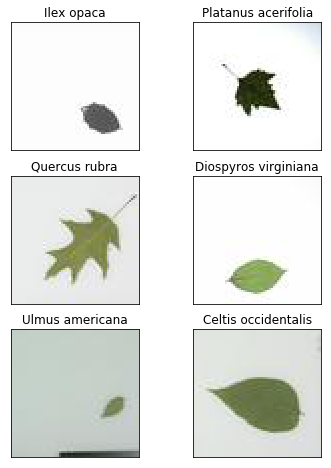

In [140]:
# display top 6
plt.figure(figsize=[6,8])
for i in range(6):
    species = errors_max6.iloc[i].name
    index = info_data[info_data['label']==species].index[0]
    img = images[index,:]
    plt.subplot(3,2,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(species)